In [2]:
!pip install torch

   ---------------------------------------- 0.0/204.1 MB ? eta -:--:--
   - -------------------------------------- 8.9/204.1 MB 55.5 MB/s eta 0:00:04
   --- ------------------------------------ 19.1/204.1 MB 52.6 MB/s eta 0:00:04
   ----- ---------------------------------- 27.8/204.1 MB 49.0 MB/s eta 0:00:04
   -------- ------------------------------- 42.5/204.1 MB 55.2 MB/s eta 0:00:03
   ---------- ----------------------------- 51.1/204.1 MB 51.7 MB/s eta 0:00:03
   ----------- ---------------------------- 59.2/204.1 MB 49.0 MB/s eta 0:00:03
   ------------- -------------------------- 67.1/204.1 MB 47.5 MB/s eta 0:00:03
   -------------- ------------------------- 75.0/204.1 MB 46.4 MB/s eta 0:00:03
   ---------------- ----------------------- 82.8/204.1 MB 45.6 MB/s eta 0:00:03
   ----------------- ---------------------- 91.0/204.1 MB 45.0 MB/s eta 0:00:03
   ------------------- -------------------- 99.1/204.1 MB 44.5 MB/s eta 0:00:03
   -------------------- ------------------ 107.2/2

In [1]:
# from transformers import BertTokenizer, BertModel

# text = "Replace me by any text you'd like."
# encoded_input = tokenizer(text, return_tensors='pt')
# output = model(**encoded_input)

from transformers import BertTokenizer, BertForSequenceClassification

In [2]:
import torch
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaTokenizer, RobertaForSequenceClassification
from torch.optim import Adam
from torch.nn.functional import cross_entropy

import functions as f

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# Загрузка данных
df_train = pd.read_csv('df_main.csv')
df_test = pd.read_csv('df_pred.csv')

In [5]:
df_train.tag.unique(), df_test.tag.unique()

(array(['rap', 'country', 'rock', 'pop', 'rb'], dtype=object),
 array(['pop', 'rock', 'rb', 'rap', 'country'], dtype=object))

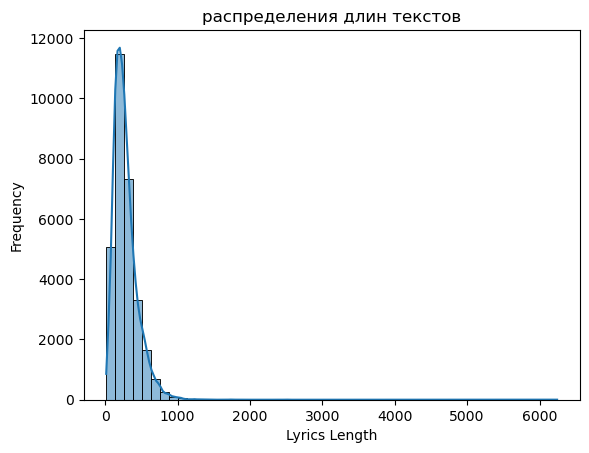

In [6]:
# Визуализация распределения длин текстов
df_train['lyrics_length'] = df_train['lyrics'].apply(lambda x: len(x.split()))
sns.histplot(df_train['lyrics_length'], bins=50, kde=True)
plt.xlabel('Lyrics Length')
plt.ylabel('Frequency')
plt.title('распределения длин текстов')
plt.show()

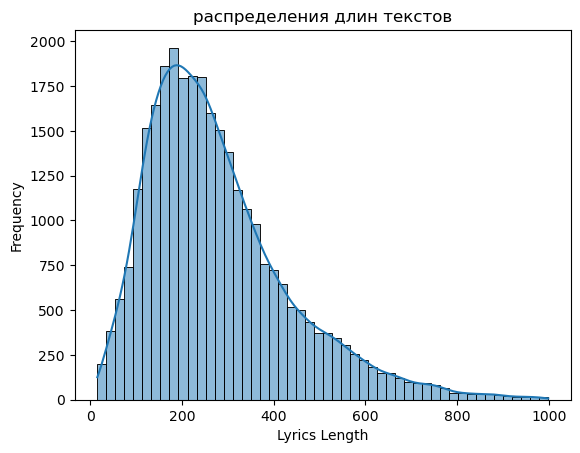

In [7]:
sns.histplot(df_train[df_train['lyrics_length'] < 1000].lyrics_length, bins=50, kde=True)
plt.xlabel('Lyrics Length')
plt.ylabel('Frequency')
plt.title('распределения длин текстов')
plt.show()

In [8]:
# Преобразуем жанры в числовые метки
labels = {'rap': 0, 'country': 1, 'rock': 2, 'pop': 3, 'rb': 4}
df_train['label'] = df_train['tag'].map(labels)
df_test['label'] = df_test['tag'].map(labels)

In [7]:
# Токенизация
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [9]:
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

In [10]:
# Создание DataLoader
train_dataset = f.LyricsDataset(df_train, tokenizer)
test_dataset = f.LyricsDataset(df_test, tokenizer)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [10]:
# Модель
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=len(labels))

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
model = BertForSequenceClassification.from_pretrained("bert-base-multilingual-cased", num_labels=len(labels))

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
model

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

In [12]:
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1

In [12]:
# # Заморозим все слои, кроме классификационной головы
# for param in model.base_model.parameters():
#     param.requires_grad = False

In [13]:
model.to(device)
optimizer = Adam(model.parameters(), lr=2e-5)

In [ ]:
# Запуск обучения
f.train_model(model, train_loader, test_loader, optimizer)

eval...: 100%|███████████████████████████████████████████████████████████████████████████| 4/4 [00:15<00:00,  3.83s/it]


Epoch 1: Train Loss: 1.0558, Test Loss: 1.2070, Test Acc: 0.5600, Test F1: 0.5641


eval...: 100%|███████████████████████████████████████████████████████████████████████████| 4/4 [00:13<00:00,  3.49s/it]


Epoch 2: Train Loss: 0.8928, Test Loss: 1.2681, Test Acc: 0.5800, Test F1: 0.5519


Epoch 3:  16%|████████▋                                             | 301/1875 [1:42:22<9:05:05, 20.78s/it, loss=0.751]

eval...: 100%|██████████| 4/4 [00:00<00:00,  4.32it/s]


Final Test Accuracy: 0.6800, Test F1 Score: 0.6820


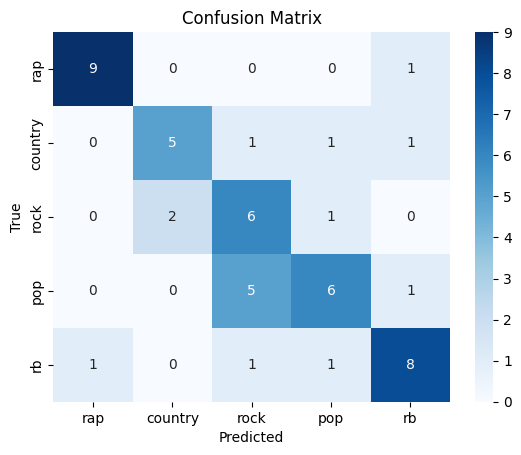

In [15]:
# Получение предсказаний на тесте
test_loss, test_acc, test_f1, true_labels, pred_labels = evaluate(model, test_loader)
print(f"Final Test Accuracy: {test_acc:.4f}, Test F1 Score: {test_f1:.4f}")

# Построение confusion matrix
conf_matrix = confusion_matrix(true_labels, pred_labels)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels.keys(), yticklabels=labels.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [16]:
# Пример предсказаний
test_texts = df_test['lyrics'].tolist()
predictions = predict(test_texts, labels)
df_test['predicted_tag'] = predictions
df_test.to_csv('predictions.csv', index=False)
print(df_test[['title', 'artist', 'predicted_tag']].head())

                title                           artist predicted_tag
0  Journey to Nowhere                   Justin Bellamy           pop
1    Comin Up for Air                    Extreme Music       country
2     Never Let Me Go                  Luther Vandross           pop
3      Worst Behavior                     Teff Hinkson           rap
4          Zombie Zoo  Tom Petty and the Heartbreakers           pop
